# Exploratory Data Analysis

We see 9 different files, each with numerous transactions along with other metadata.

Let us drill down and see what we can find. 

In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt


import seaborn as sns

import datetime
import numpy as np

Importing files

In [2]:
files = glob.glob("data/*.csv")

In [3]:
columns = ['sku', 'brand', 'cat', 'bill', 'store', 'date', 'type', 'mrp', 'price', 'qty']

The 'source' column below is a marker to indicate file origin of the observation 

In [4]:
#Helper function to read multiple csv files and store it in a dictionary. Found in helper.py

from helper import read_files

In [5]:
df_dict = read_files(files, columns)

#    

##### Question 1 - The data is split into 9 files. Does it mean anything? 

In [6]:
#Helper function to test for overlap in the different files. Found in helper.py

from helper import overlap

In [7]:
#A few random checks for overlaps

overlap(df_dict['df1'], df_dict['df2'], 'sku')

'Overlaps found for sku'

In [8]:
overlap(df_dict['df1'], df_dict['df6'], 'brand')

'Overlaps found for brand'

In [9]:
overlap(df_dict['df4'], df_dict['df7'], 'bill')

'There is no overlap'

##### Answer-  It appears that the transactions are put into different files on the basis of different bill numbers

We assume that other than this, there is not much difference between the transactions in the files.

Hence, we are going to concatenate all the 9 files into one big file. 

In [10]:
df = pd.concat(df for df in df_dict.values())

In [11]:
# Overview of data

In [12]:
num_skus = df['sku'].nunique()

num_cats = df['cat'].nunique()

num_stores = df['store'].nunique()

num_bills = df['bill'].nunique()

num_days = df['date'].nunique()

start_date, end_date = df['date'].min(), df['date'].max()

print("There are {} unique SKUs across {} categories in {} stores.\n".format(num_skus, num_cats, num_stores))

print("The number of separate bills are {} recorded on {} days, starting from {} to {}.".format(num_bills, num_days, start_date, end_date))

There are 4289 unique SKUs across 11 categories in 6 stores.

The number of separate bills are 27191 recorded on 424 days, starting from 2017-01-01 to 2018-02-28.


#     

### Data cleaning and formatting

We keep store number only instead of the string

In [13]:
df['store'] = df['store'].apply(lambda x: x[-1])

###### 1) Handling duplicate values

In [14]:
num_duplicated = df.duplicated(keep='first').sum()

print("There are {} duplicate rows".format(num_duplicated))

There are 3889 duplicate rows


We drop the duplicate rows on second occurrence 

In [15]:
df = df.drop_duplicates(keep="first")

###### 2) Handling missing values

In [16]:
df.isna().sum()

sku        0
brand     11
cat        9
bill       0
store      0
date       0
type       0
mrp        0
price      0
qty        0
source     0
dtype: int64

###### Only brand and cat columns have missing values. Let's investigate further. 

In [17]:
# Subset where brand is NaN

df[df['brand'].isnull()]

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source
10,SKU0726,NaN,Cat01,BILL02585,6,2017-07-19,Sale,54.67,54.67,1,9
29,SKU2585,NaN,NaN,BILL09133,3,2017-09-09,Sale,2.60,2.60,1,4
1278,SKU2649,NaN,NaN,BILL09643,3,2017-09-06,Sale,8.00,8.00,1,4
1372,SKU2653,NaN,NaN,BILL09736,3,2017-09-07,Sale,30.00,30.00,1,4
1373,SKU2649,NaN,NaN,BILL09737,3,2017-09-07,Sale,8.00,8.00,1,4
1434,SKU2654,NaN,NaN,BILL09771,3,2017-09-07,Sale,9.67,9.67,1,4
1478,SKU2657,NaN,NaN,BILL09798,3,2017-09-08,Sale,3.73,0.00,1,4
1482,SKU2658,NaN,NaN,BILL09802,3,2017-09-08,Sale,4.33,4.33,1,4
1490,SKU2659,NaN,NaN,BILL09809,3,2017-09-08,Sale,4.33,4.33,1,4
1506,SKU2661,NaN,NaN,BILL09825,3,2017-09-08,Sale,3.99,3.99,1,4


###### Instead of throwing the data away, we replace missing brands by 'UnkBRAND' and missing categories by 'UnkCAT'

In [18]:
df.loc[df['brand'].isnull(), 'brand'] = 'UnkBRAND'

df.loc[df['cat'].isnull(), 'cat'] = 'UnkCAT'

###### 3) Extracting day, month, dayofweek and weekend flag from date

In [19]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = pd.DatetimeIndex(df['date']).day

df['month'] = pd.DatetimeIndex(df['date']).month_name()

df['dayofweek'] = pd.DatetimeIndex(df['date']).day_name()

weekend_days = ['Saturday', 'Sunday']

df['weekend'] = np.where(df['dayofweek'].isin(weekend_days), 1, 0)

df['weekno'] = df.date.dt.week

###### 5) Binning SKUs by price  

#    

###### Question - Notice that there are transactions with zero quantity. Examining the dataset confirms this. 
###### What do we do here? 

In [20]:
zero_qty = df[df['qty'] == 0]

zero_qty.head()

,sku,brand,cat,bill,store,date,type,mrp,price,qty,source,day,month,dayofweek,weekend,weekno
10122,SKU0651,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10123,SKU0663,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10124,SKU0630,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10125,SKU0635,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46
10126,SKU0634,BRAND027,Cat04,BILL16591,5,2017-11-16,Sale,1.33,1.33,0,6,16,November,Thursday,0,46


###### Answer - Zero quantity transactions don't make sense. Also, their MRP and price are equal (at 1.33), even though they are different SKUs. This suggests it is probably noise. So we remove these transactions. 

In [21]:
df = df[df['qty'] != 0]

#     

###### Question - Is there anything peculiar about the SKUs that are recorded as sold at zero quantity? 

In [22]:
zero_qty_skus = zero_qty.sku.unique()

zero_qty_skus

array(['SKU0651', 'SKU0663', 'SKU0630', 'SKU0635', 'SKU0634', 'SKU0627',
       'SKU0638', 'SKU0632', 'SKU0667', 'SKU0637', 'SKU0653', 'SKU0633',
       'SKU0639', 'SKU0642', 'SKU0641', 'SKU0636', 'SKU0650', 'SKU0654',
       'SKU0648', 'SKU2134'], dtype=object)

In [23]:
for sku in zero_qty_skus:
    print("Price: ", set(df[df['sku'] == sku]['price']),
         "Qty: ", set(df[df['sku'] == sku]['qty']))

Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -2, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, -4, -1}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, 5, 6, 7}
Price:  {0.0, 1.33} Qty:  {1, 2, 3}
Price:  {0.0, 1.33} Qty:  {1, 2, 3, 4, -1}


###### Answer - All of them are priced at either 0 or 1.33, and the quantity fluctuates. 

###### For further investigation we need more information about the SKUs from the source, but since this is an anonymous dataset, this is not possible. 

###### Hence, even though they appear to be noise (at a cursory glance), we retain these transactions for now.

#  

We see if there is overcharging (where price is greater than MRP)

In [24]:
overcharged = df[df['price'] > df['mrp'] ]

print(overcharged.shape[0])

overcharged[['mrp', 'price']].tail()

1665


,mrp,price
11420,20.00,22.00
11428,22.00,24.00
11431,55.33,60.00
11432,88.00,96.00
11496,88.67,96.67


Overcharging does happen on 1665 transactions. Some of these SKUs have MRP = 0.

One possible explanation for this is that these SKUs were intended to be discounted, but were sold at a higher price, mistakenly or otherwise.

For the sake of simplicity, we 'rectify' this issue by forcing the MRP to match the price (since price is what the customer has already paid). 

###### We assume the MRP was entered wrongly and so the discount is zero. Not recommended in an actual setting.  

In [25]:
df['mrp'] = np.where(df.price > df.mrp, df.price, df.mrp)

#   

###### Some of the SKUs have MRP.= 0. We investigate it. 

In [26]:
zero_mrp = df[df['mrp'] == 0]

zero_mrp_skus = zero_mrp.sku.unique().tolist() 

In [27]:
print("{} transactions have zero MRP, which is recorded under {} different SKUs.".format(zero_mrp.shape[0], len(zero_mrp_skus)))

699 transactions have zero MRP, which is recorded under 123 different SKUs.


###### Question - Are these SKUs always sold for MRP = 0 every time?    

In [28]:
zero_mrp_skus_avg_mrps = df[(df['sku'].isin(zero_mrp_skus)) & (df['mrp'] != 0)].groupby('sku')['mrp'].agg(lambda x : np.mean(x))

zero_mrp_skus_avg_mrps

sku
SKU3676    0.01
Name: mrp, dtype: float64

###### Just one transaction with an MRP of 0.01. This is almost certainly an anomaly. 

###### So we can discard all MRPs that are 0. 

In [29]:
df =  df[df['mrp'] != 0]

In [30]:
###### 4) Creating total price, discount and percentage discount features

In [31]:
df['total'] = df['price'] * df['qty']

df['discount'] = df['mrp'] - df['price']

df['perc_discount'] = ((df['mrp'] - df['price']) / df['mrp']) * 100

#    

### Metric 1: Transaction count

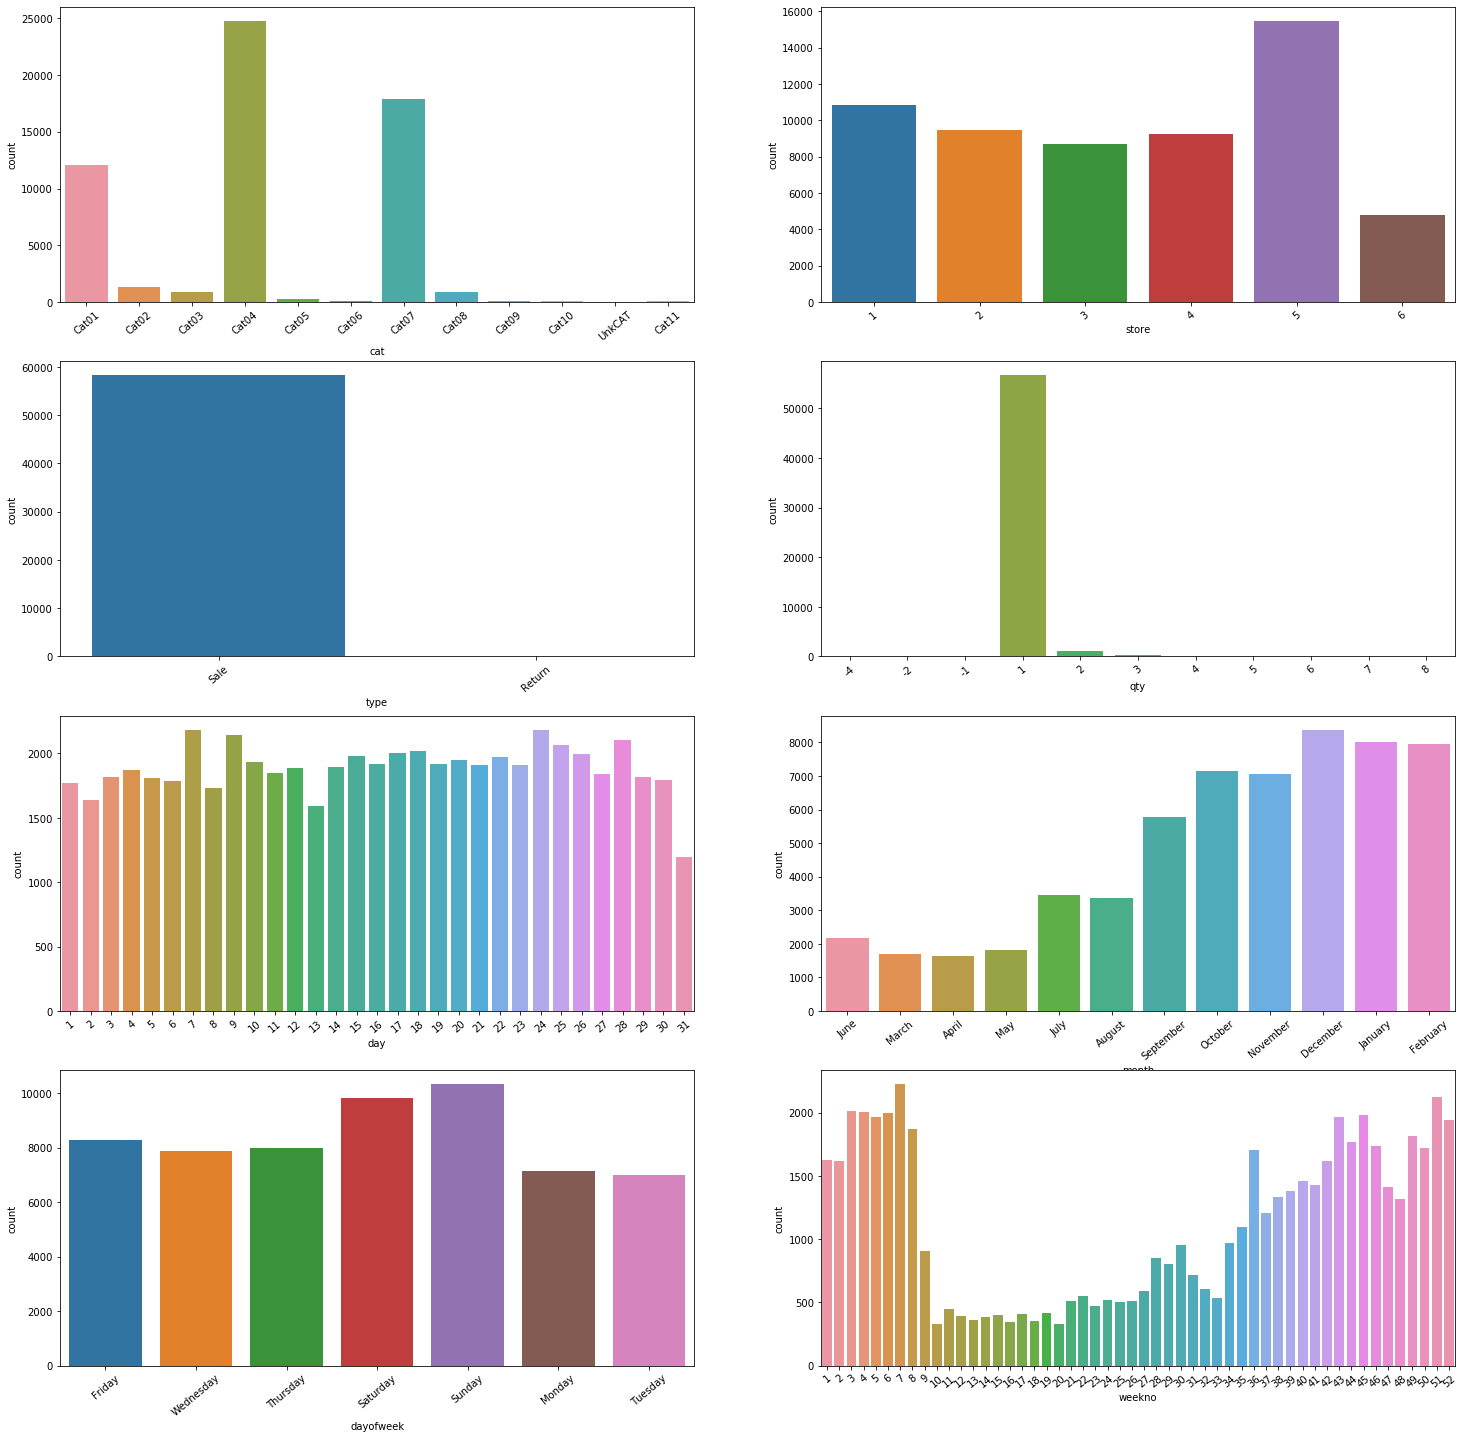

In [32]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

#plt.setp(fig.xaxis.get_majorticklabels(), rotation=45)

#axs.tickp


cat_trans_count_plot = sns.countplot(df['cat'], ax=axs[0,0])
cat_trans_count_plot.set_xticklabels(cat_trans_count_plot.get_xticklabels(), rotation=40);

store_trans_count_plot = sns.countplot(df['store'], ax=axs[0,1])
store_trans_count_plot.set_xticklabels(store_trans_count_plot.get_xticklabels(), rotation=40);

sale_type_trans_count_plot = sns.countplot(df['type'], ax=axs[1,0])
sale_type_trans_count_plot.set_xticklabels(sale_type_trans_count_plot.get_xticklabels(), rotation=40);
    
qty_trans_count_plot = sns.countplot(df['qty'], ax=axs[1,1])
qty_trans_count_plot.set_xticklabels(qty_trans_count_plot.get_xticklabels(), rotation=40);

day_trans_count_plot = sns.countplot(df['day'], ax=axs[2,0])
day_trans_count_plot.set_xticklabels(day_trans_count_plot.get_xticklabels(), rotation=40);

month_trans_count_plot = sns.countplot(df['month'], ax=axs[2,1])
month_trans_count_plot.set_xticklabels(month_trans_count_plot.get_xticklabels(), rotation=40);

dayofweek_trans_count_plot = sns.countplot(df['dayofweek'], ax=axs[3,0])
dayofweek_trans_count_plot.set_xticklabels(dayofweek_trans_count_plot.get_xticklabels(), rotation=40);

weekno_trans_count_plot = sns.countplot(df['weekno'], ax=axs[3,1])
weekno_trans_count_plot.set_xticklabels(weekno_trans_count_plot.get_xticklabels(), rotation=40);

#for ax in fig.axes:
 #   plt.xticks(rotation=45)





###### Key takeaways - 

1) SKUs of Category 4, 7 and 1 are highest-selling by transaction count. Store 5 has the most number of transactions. 

2) Most SKUs are sold in singular quantities. The vast majority of transactions are sales.  

3) Sales spike in the weekends. Monday is the least busy day. 

4) There is a sudden slump after week 9 all the way to week 33. Needs more investigating. 

#   

### Metric 2:  Quantity of SKU

In [33]:
from helper import barplot

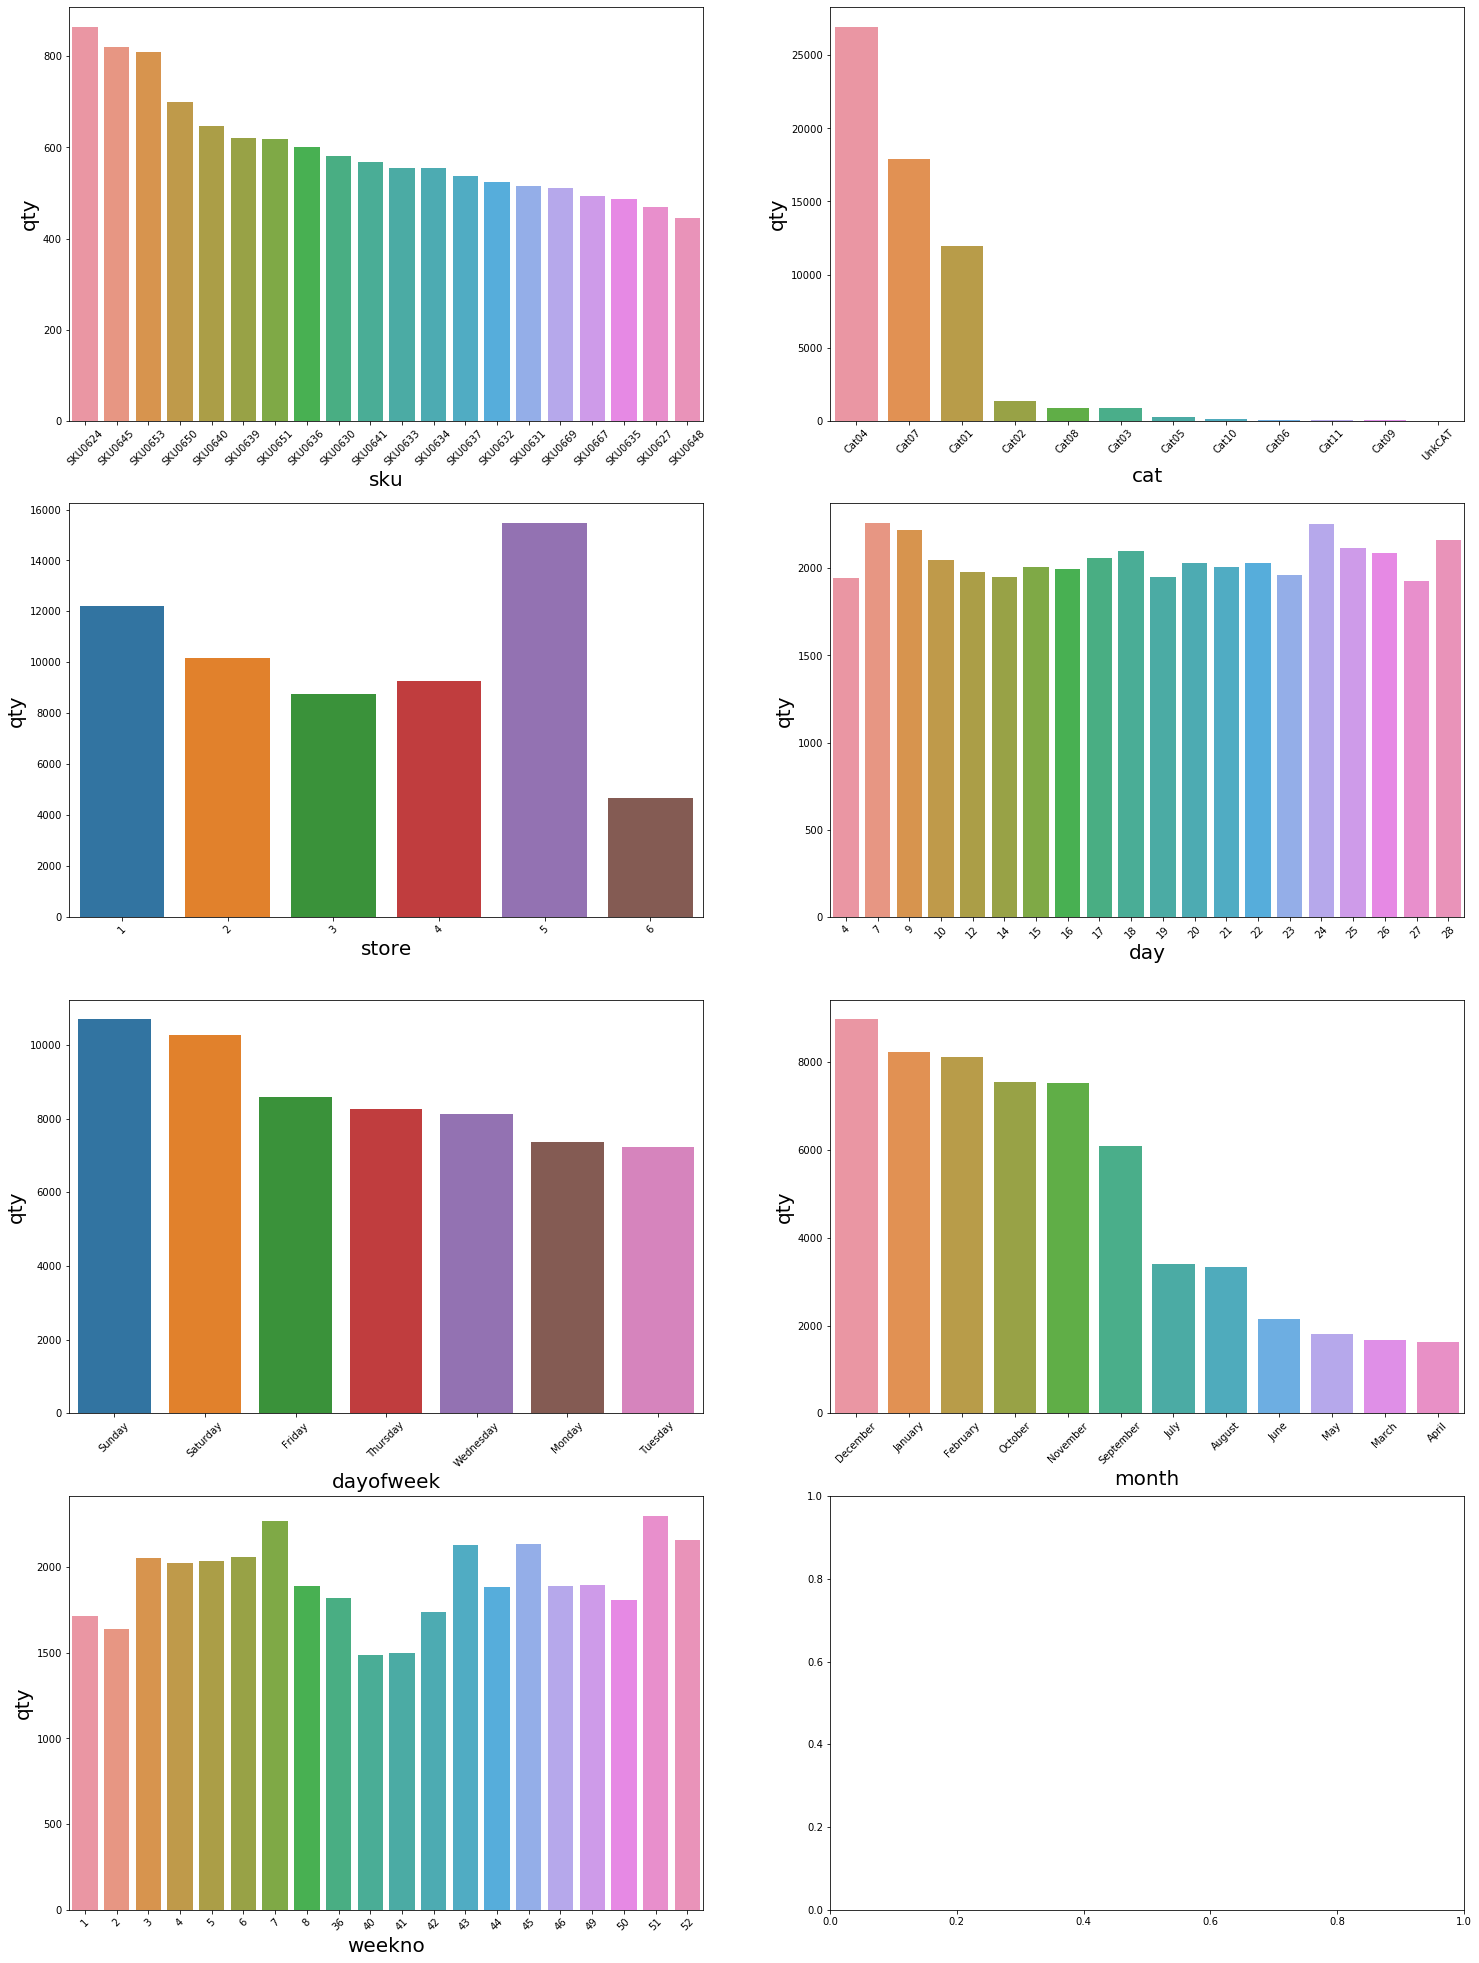

In [34]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

qty_per_sku, qty_per_sku_plot = barplot(df, 'sku', 'qty', axs[0,0])

qty_per_cat, qty_per_cat_plot = barplot(df, 'cat', 'qty', axs[0,1])

qty_per_store, qty_per_store_plot = barplot(df, 'store', 'qty', axs[1,0])

qty_per_day, qty_per_day_plot = barplot(df, 'day', 'qty', axs[1,1])

qty_per_dayofweek, qty_per_dayofweek_plot = barplot(df, 'dayofweek', 'qty', axs[2,0])

qty_per_month, qty_per_month_plot = barplot(df, 'month', 'qty', axs[2,1])

qty_per_weekno, qty_per_weekno_plot = barplot(df, 'weekno', 'qty', axs[3,0])




In [52]:
print("The top 10 selling SKUs are \n{}".format(qty_per_sku[:10]))

The top 10 selling SKUs are 
         qty
sku         
SKU0624  865
SKU0645  821
SKU0653  809
SKU0650  699
SKU0640  648
SKU0639  620
SKU0651  619
SKU0636  601
SKU0630  581
SKU0641  568


In [50]:
top_selling_sku_cats = df[df['sku'].isin(qty_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by count are as follows: \n{}".format(top_selling_sku_cats))

The categories of the top 20 SKUs by count are as follows: 
Cat04    10650
Name: cat, dtype: int64


In [51]:
top_selling_sku_stores = df[df['sku'].isin(qty_per_sku.index)]['store'].value_counts()

print("The stores of the top 20 SKUs by count are as follows: \n{}".format(top_selling_sku_stores))

The stores of the top 20 SKUs by count are as follows: 
5    3189
2    2328
1    2090
4    1941
3    1080
6      22
Name: store, dtype: int64


###### Key takeaways - 

1. All of the top 20 selling SKUs belong to category 4. Approx. 30% of them are sold in Store 5 alone. 

2. Category 4 has the highest selling SKUs by quantity overall, followed by Category 7 and Category 1. The rest are very low volume in comparison. 

3. Store 5 has the highest quantities sold overall. Store 6 is by far the lowest. 

4. Weekends have higher sales volume. 

5. There is a slump in sales volume between March to July. This can be seen in the monthwise and weekwise plots. 

#     

### Metric 3: Total revenue

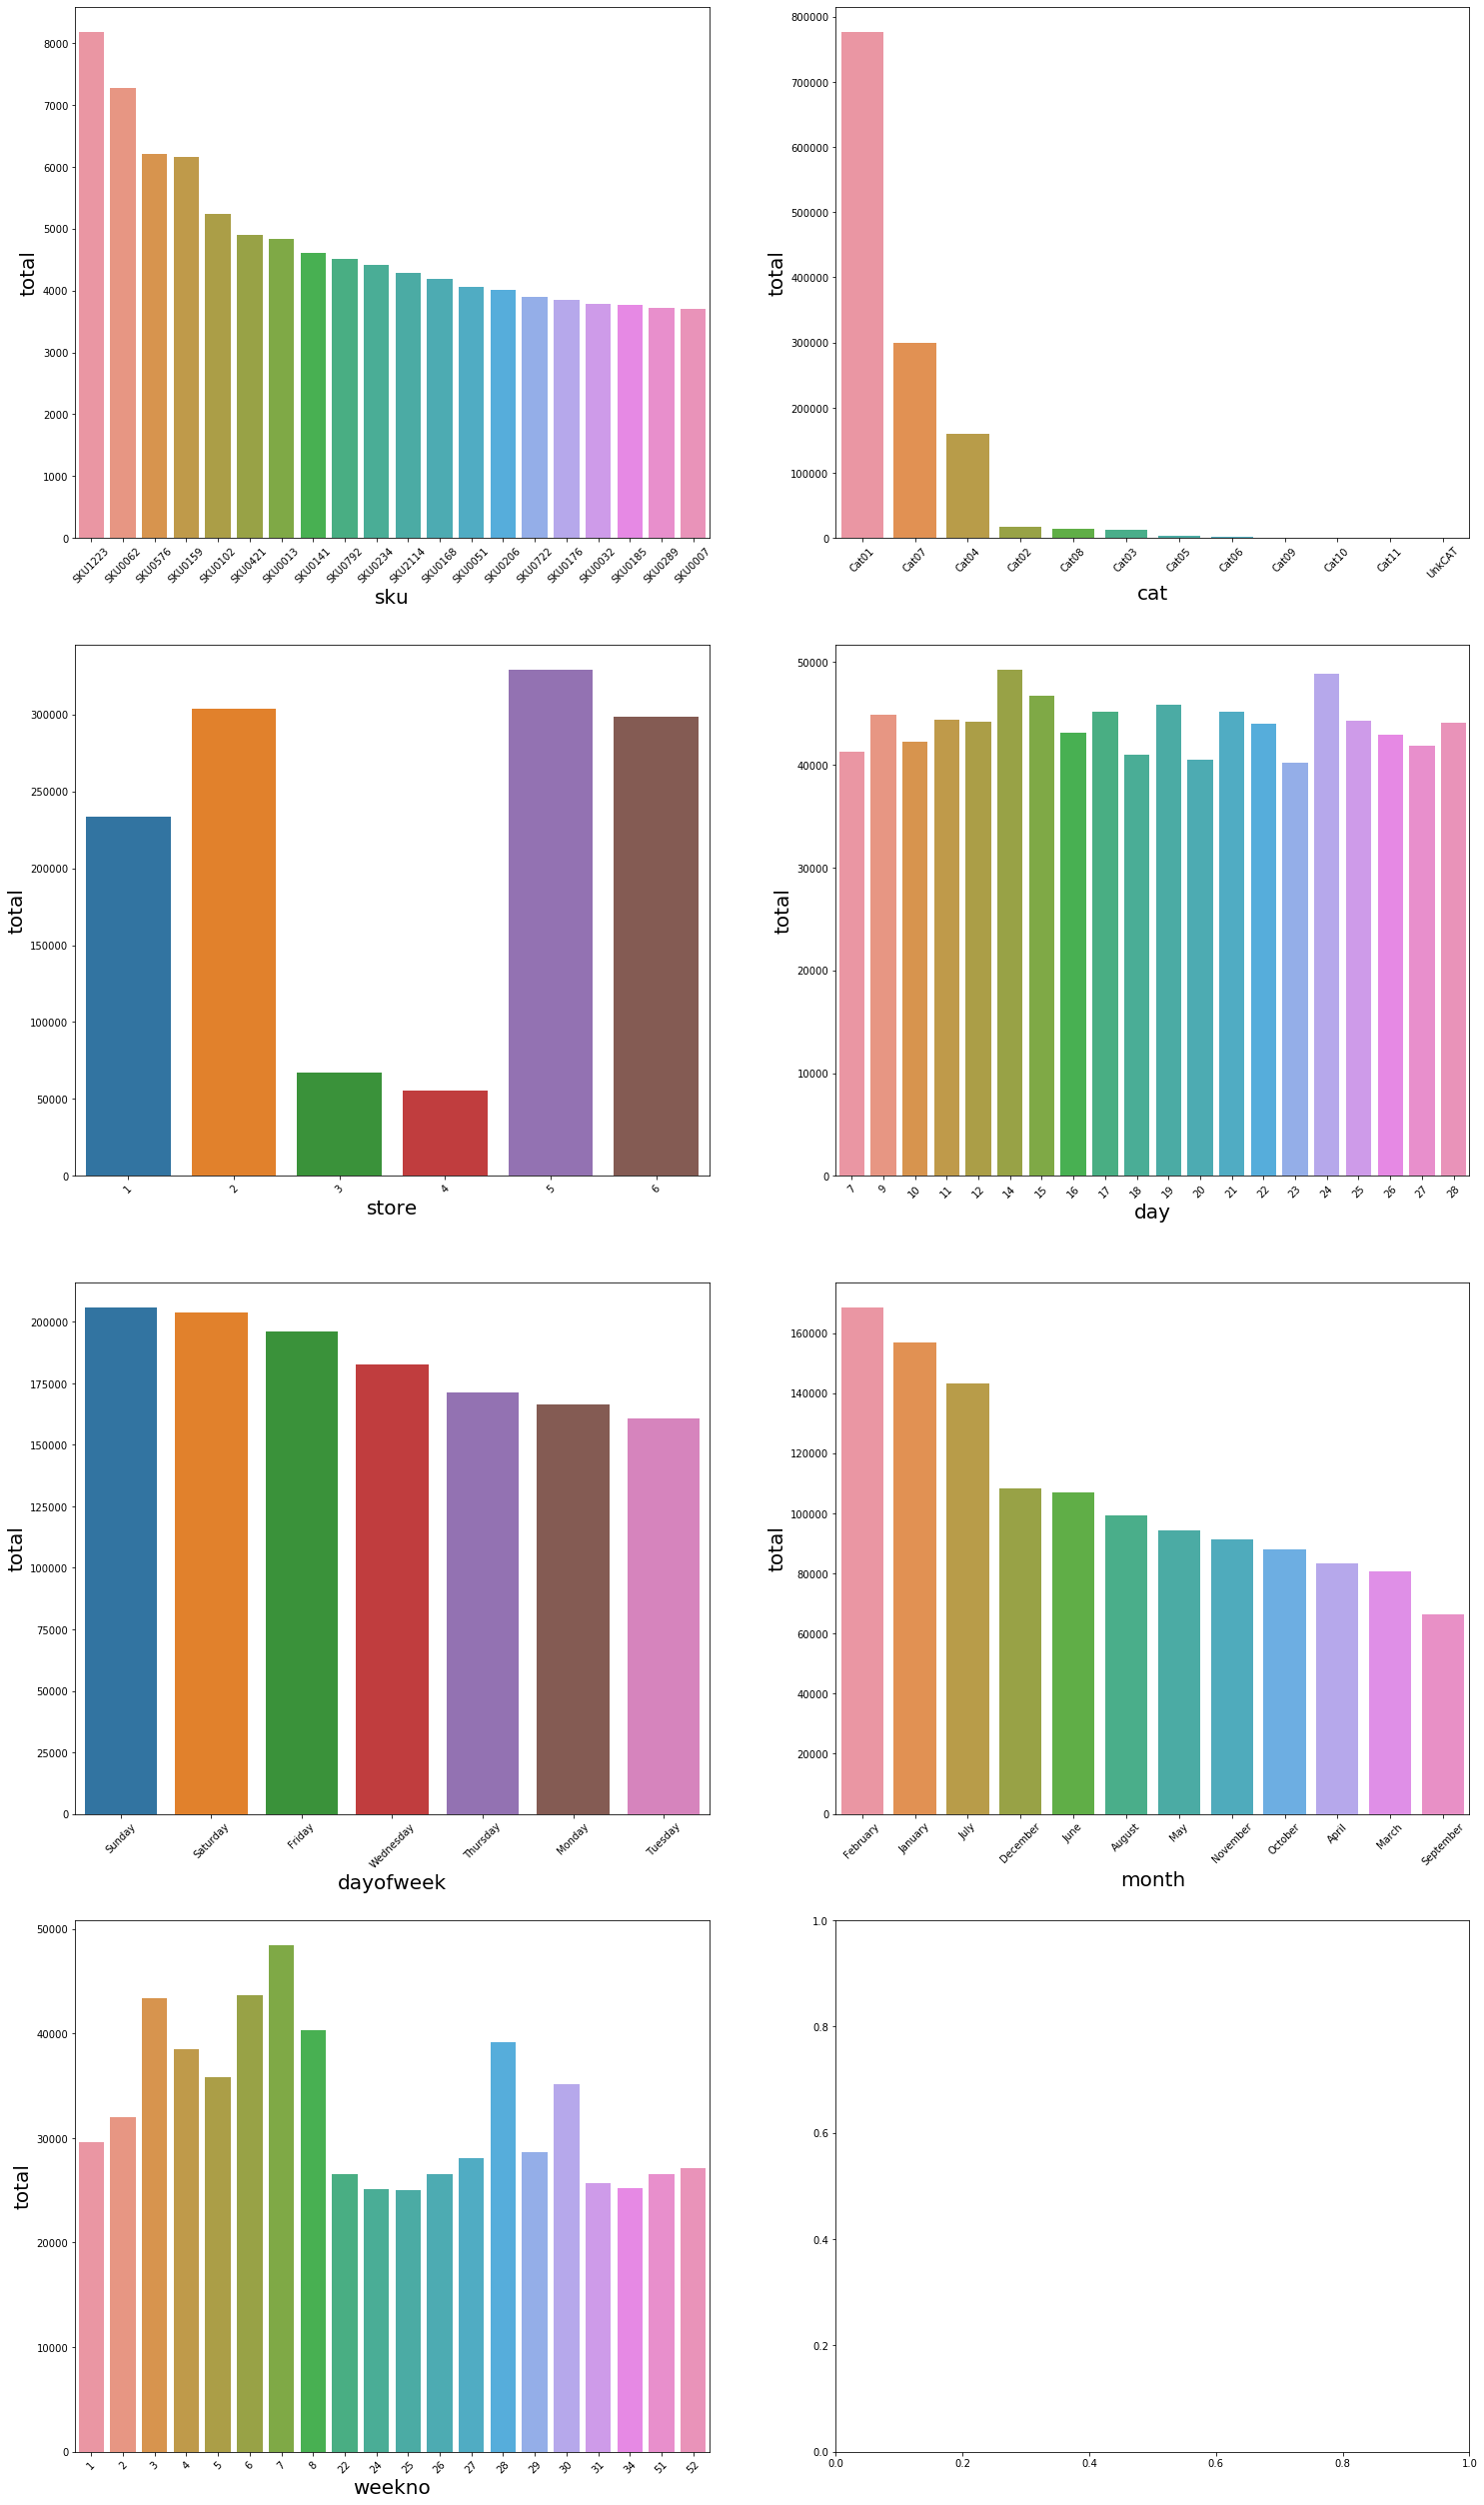

In [40]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

total_per_sku, total_per_sku_plot = barplot(df, 'sku', 'total', axs[0,0])

total_per_cat, total_per_cat_plot = barplot(df, 'cat', 'total', axs[0,1])

total_per_store, total_per_store_plot = barplot(df, 'store', 'total', axs[1,0])

total_per_day, total_per_day_plot = barplot(df, 'day', 'total', axs[1,1])

total_per_dayofweek, total_per_dayofweek_plot = barplot(df, 'dayofweek', 'total', axs[2,0])

total_per_month, total_per_month_plot = barplot(df, 'month', 'total', axs[2,1])

total_per_weekno, total_per_weekno_plot = barplot(df, 'weekno', 'total', axs[3,0])

In [42]:
print("The top 10 SKUs with highest total revenue are \n{}".format(total_per_sku[:10]))

The top 10 SKUs with highest revenue are            total
sku             
SKU1223  8181.08
SKU0062  7277.60
SKU0576  6214.66
SKU0159  6151.90
SKU0102  5244.00
SKU0421  4898.17
SKU0013  4831.85
SKU0141  4610.53
SKU0792  4506.13
SKU0234  4417.81


In [49]:
top_total_sku_cats = df[df['sku'].isin(total_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by count are as follows: \n{}".format(top_total_sku_cats))

The categories of the top 20 SKUs by count are as follows: 
Cat01    999
Cat04    182
Cat07     47
Cat08     25
Name: cat, dtype: int64


In [47]:
top_total_sku_stores = df[df['sku'].isin(total_per_sku.index)]['store'].value_counts()

top_total_sku_stores

2    406
6    362
5    245
1    228
3      7
4      5
Name: store, dtype: int64

#   

# Metric 4: Discount

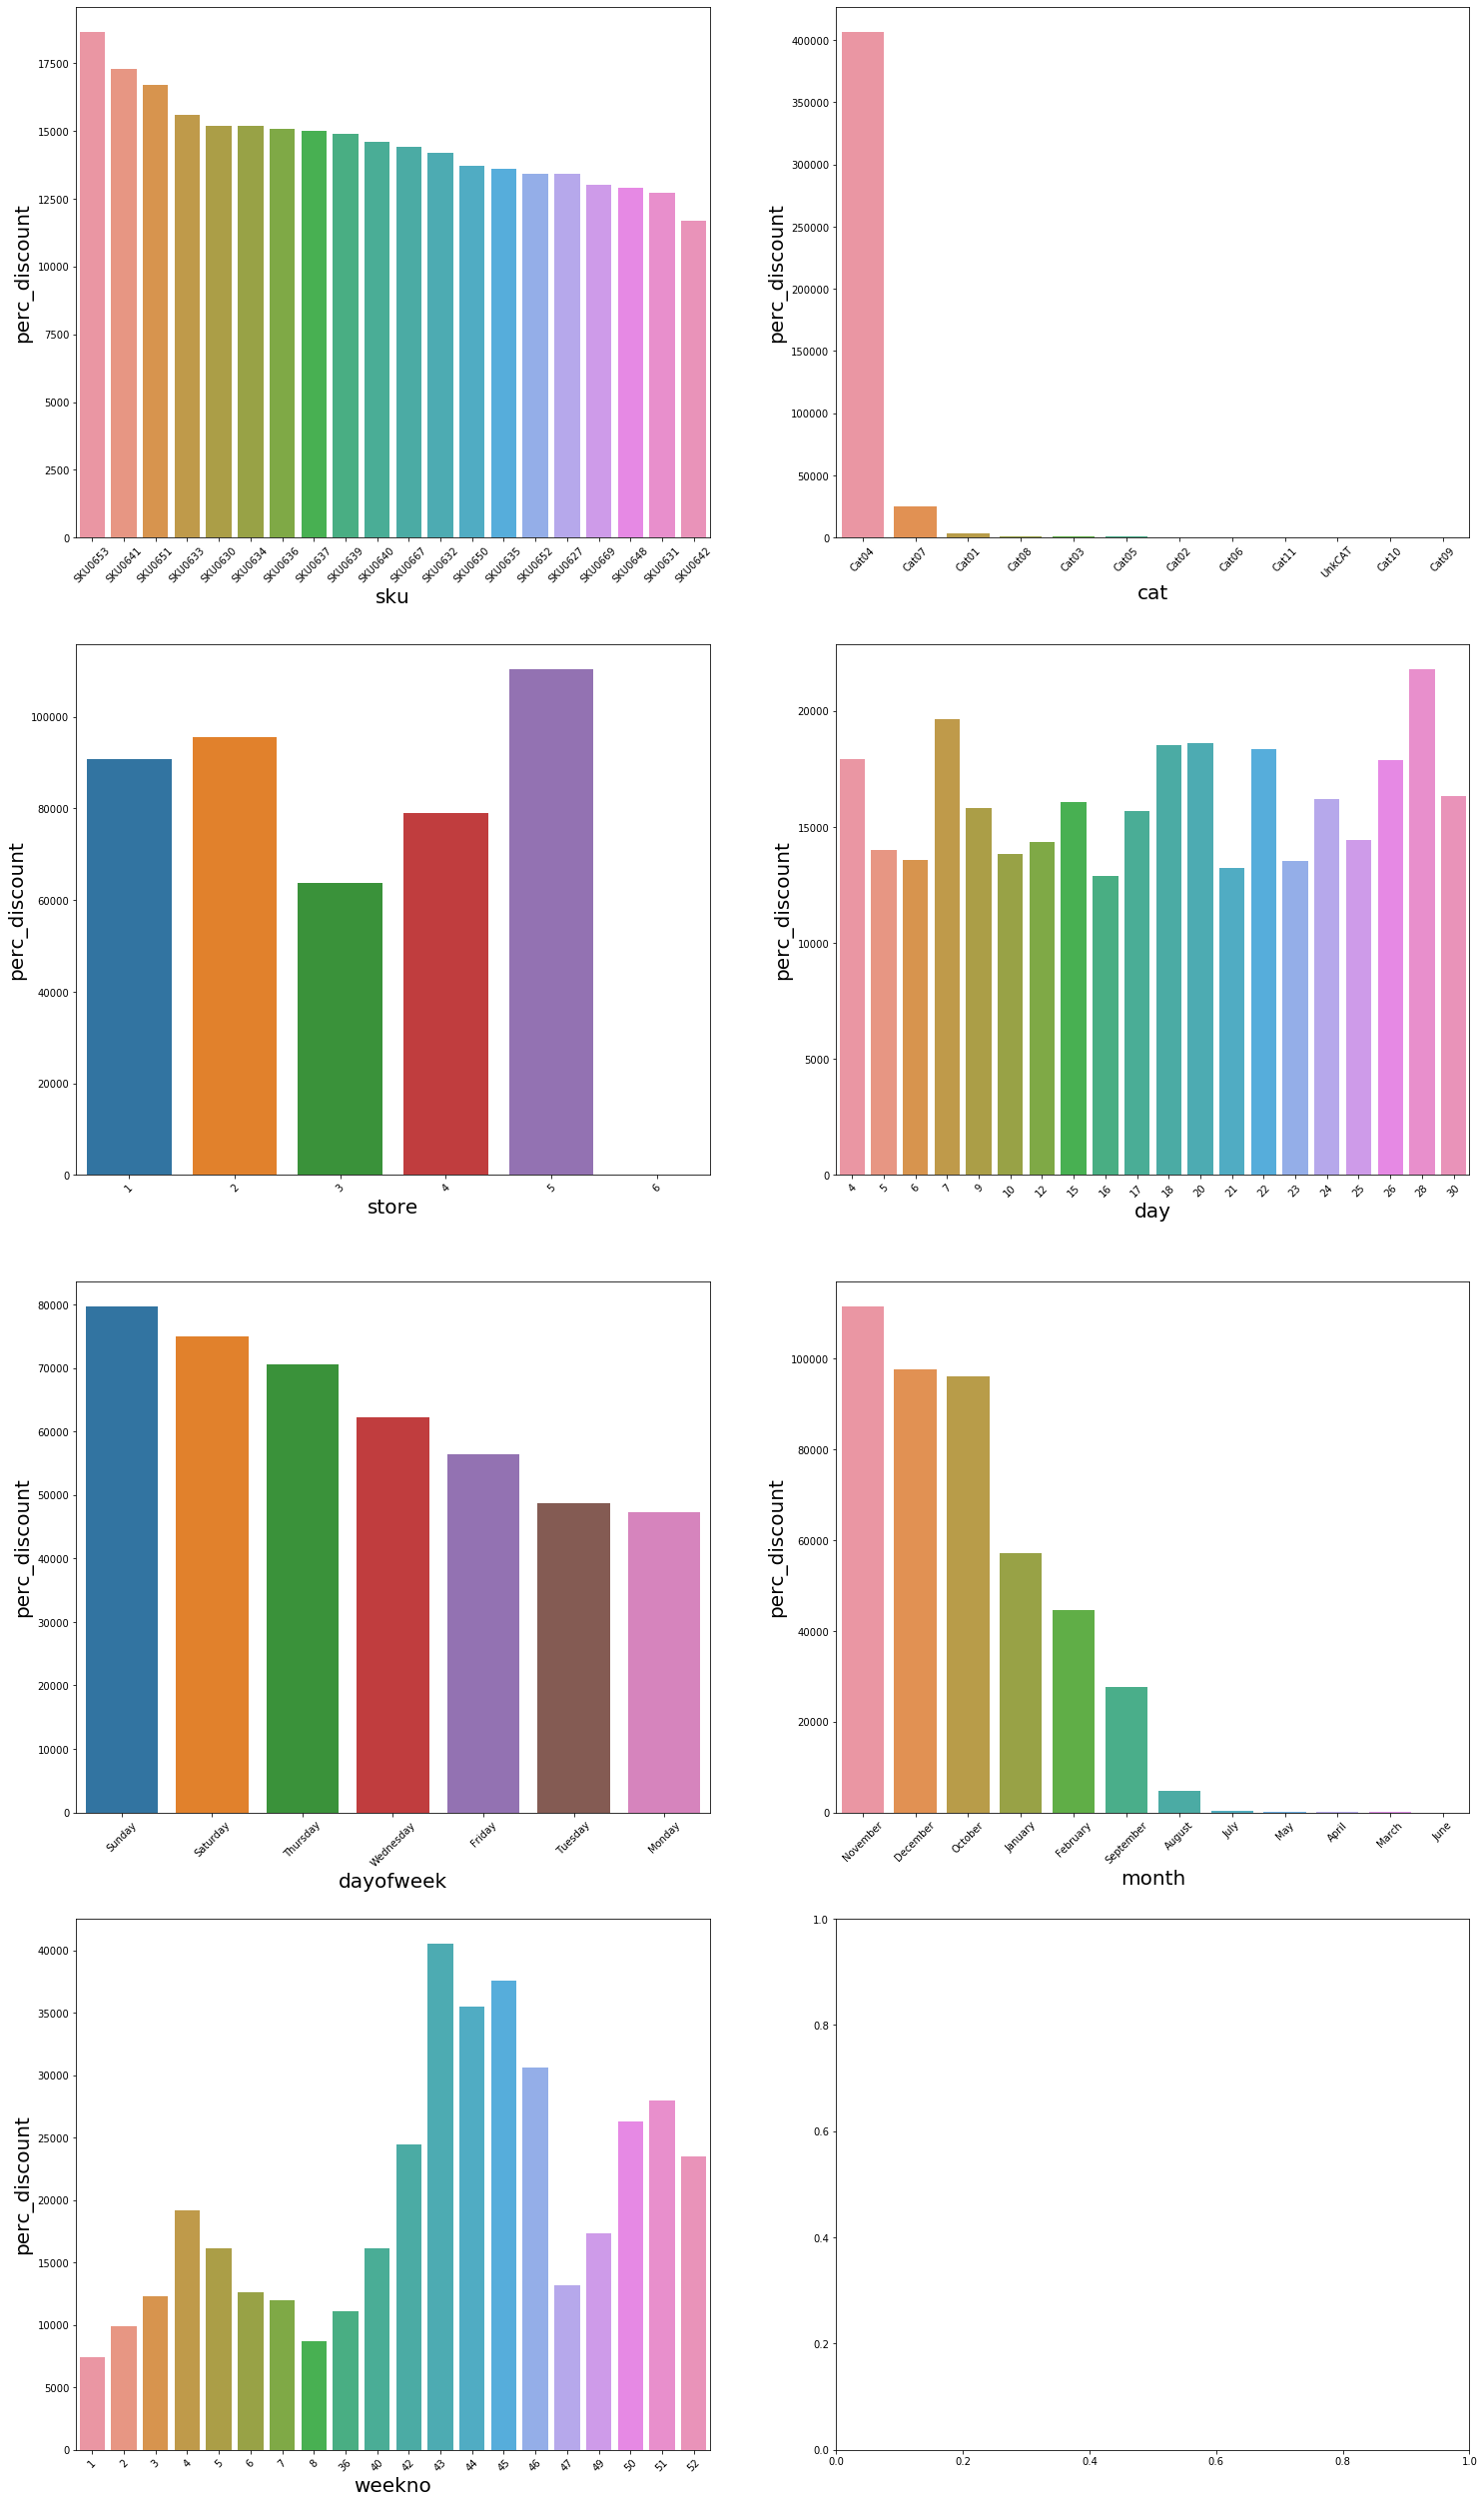

In [59]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

perc_discount_per_sku, perc_discount_per_sku_plot = barplot(df, 'sku', 'perc_discount', axs[0,0])

perc_discount_cat, perc_discount_per_cat_plot = barplot(df, 'cat', 'perc_discount', axs[0,1])

perc_discount_per_store, perc_discount_per_store_plot = barplot(df, 'store', 'perc_discount', axs[1,0])

perc_discount_per_day, perc_discount_per_day_plot = barplot(df, 'day', 'perc_discount', axs[1,1])

perc_discount_per_dayofweek, perc_discount_per_dayofweek_plot = barplot(df, 'dayofweek', 'perc_discount', axs[2,0])

perc_discount_per_month, perc_discount_per_month_plot = barplot(df, 'month', 'perc_discount', axs[2,1])

perc_discount_per_weekno, perc_discount_per_weekno_plot = barplot(df, 'weekno', 'perc_discount', axs[3,0])

In [60]:
print("The top 10 SKUs with highest percentage discount are \n{}".format(perc_discount_per_sku[:10]))

The top 10 SKUs with highest percentage discount are 
         perc_discount
sku                   
SKU0653   18650.187266
SKU0641   17300.000000
SKU0651   16700.000000
SKU0633   15600.000000
SKU0630   15200.000000
SKU0634   15200.000000
SKU0636   15081.000000
SKU0637   15000.000000
SKU0639   14900.000000
SKU0640   14600.000000


In [63]:
top_perc_discount_sku_cats = df[df['sku'].isin(perc_discount_per_sku.index)]['cat'].value_counts()

print("The categories of the top 20 SKUs by count are as follows: \n{}".format(top_perc_discount_sku_cats))

The categories of the top 20 SKUs by count are as follows: 
Cat04    10013
Name: cat, dtype: int64


In [65]:
top_perc_discount_sku_stores = df[df['sku'].isin(perc_discount_per_sku.index)]['store'].value_counts()

print("The stores of the top 20 SKUs by count are as follows: \n{}".format(top_perc_discount_sku_stores))

The stores of the top 20 SKUs by count are as follows: 
5    2976
2    2187
4    1928
1    1852
3    1048
6      22
Name: store, dtype: int64


In [ ]:
###### Key takeaways -

1. 

#    

### Metric: Mean selling price per week

In [69]:
df_mean_price = df.groupby(['sku', 'weekno'])['price'].mean()

df_mean_price

sku      weekno
SKU0001  3         92.00
         14        92.00
         16        92.00
         23        92.00
         25        92.00
                   ...  
SKU4325  9         89.00
SKU4326  9          7.99
SKU4327  9          4.00
SKU4328  9          8.67
SKU4329  9         17.71
Name: price, Length: 26428, dtype: float64

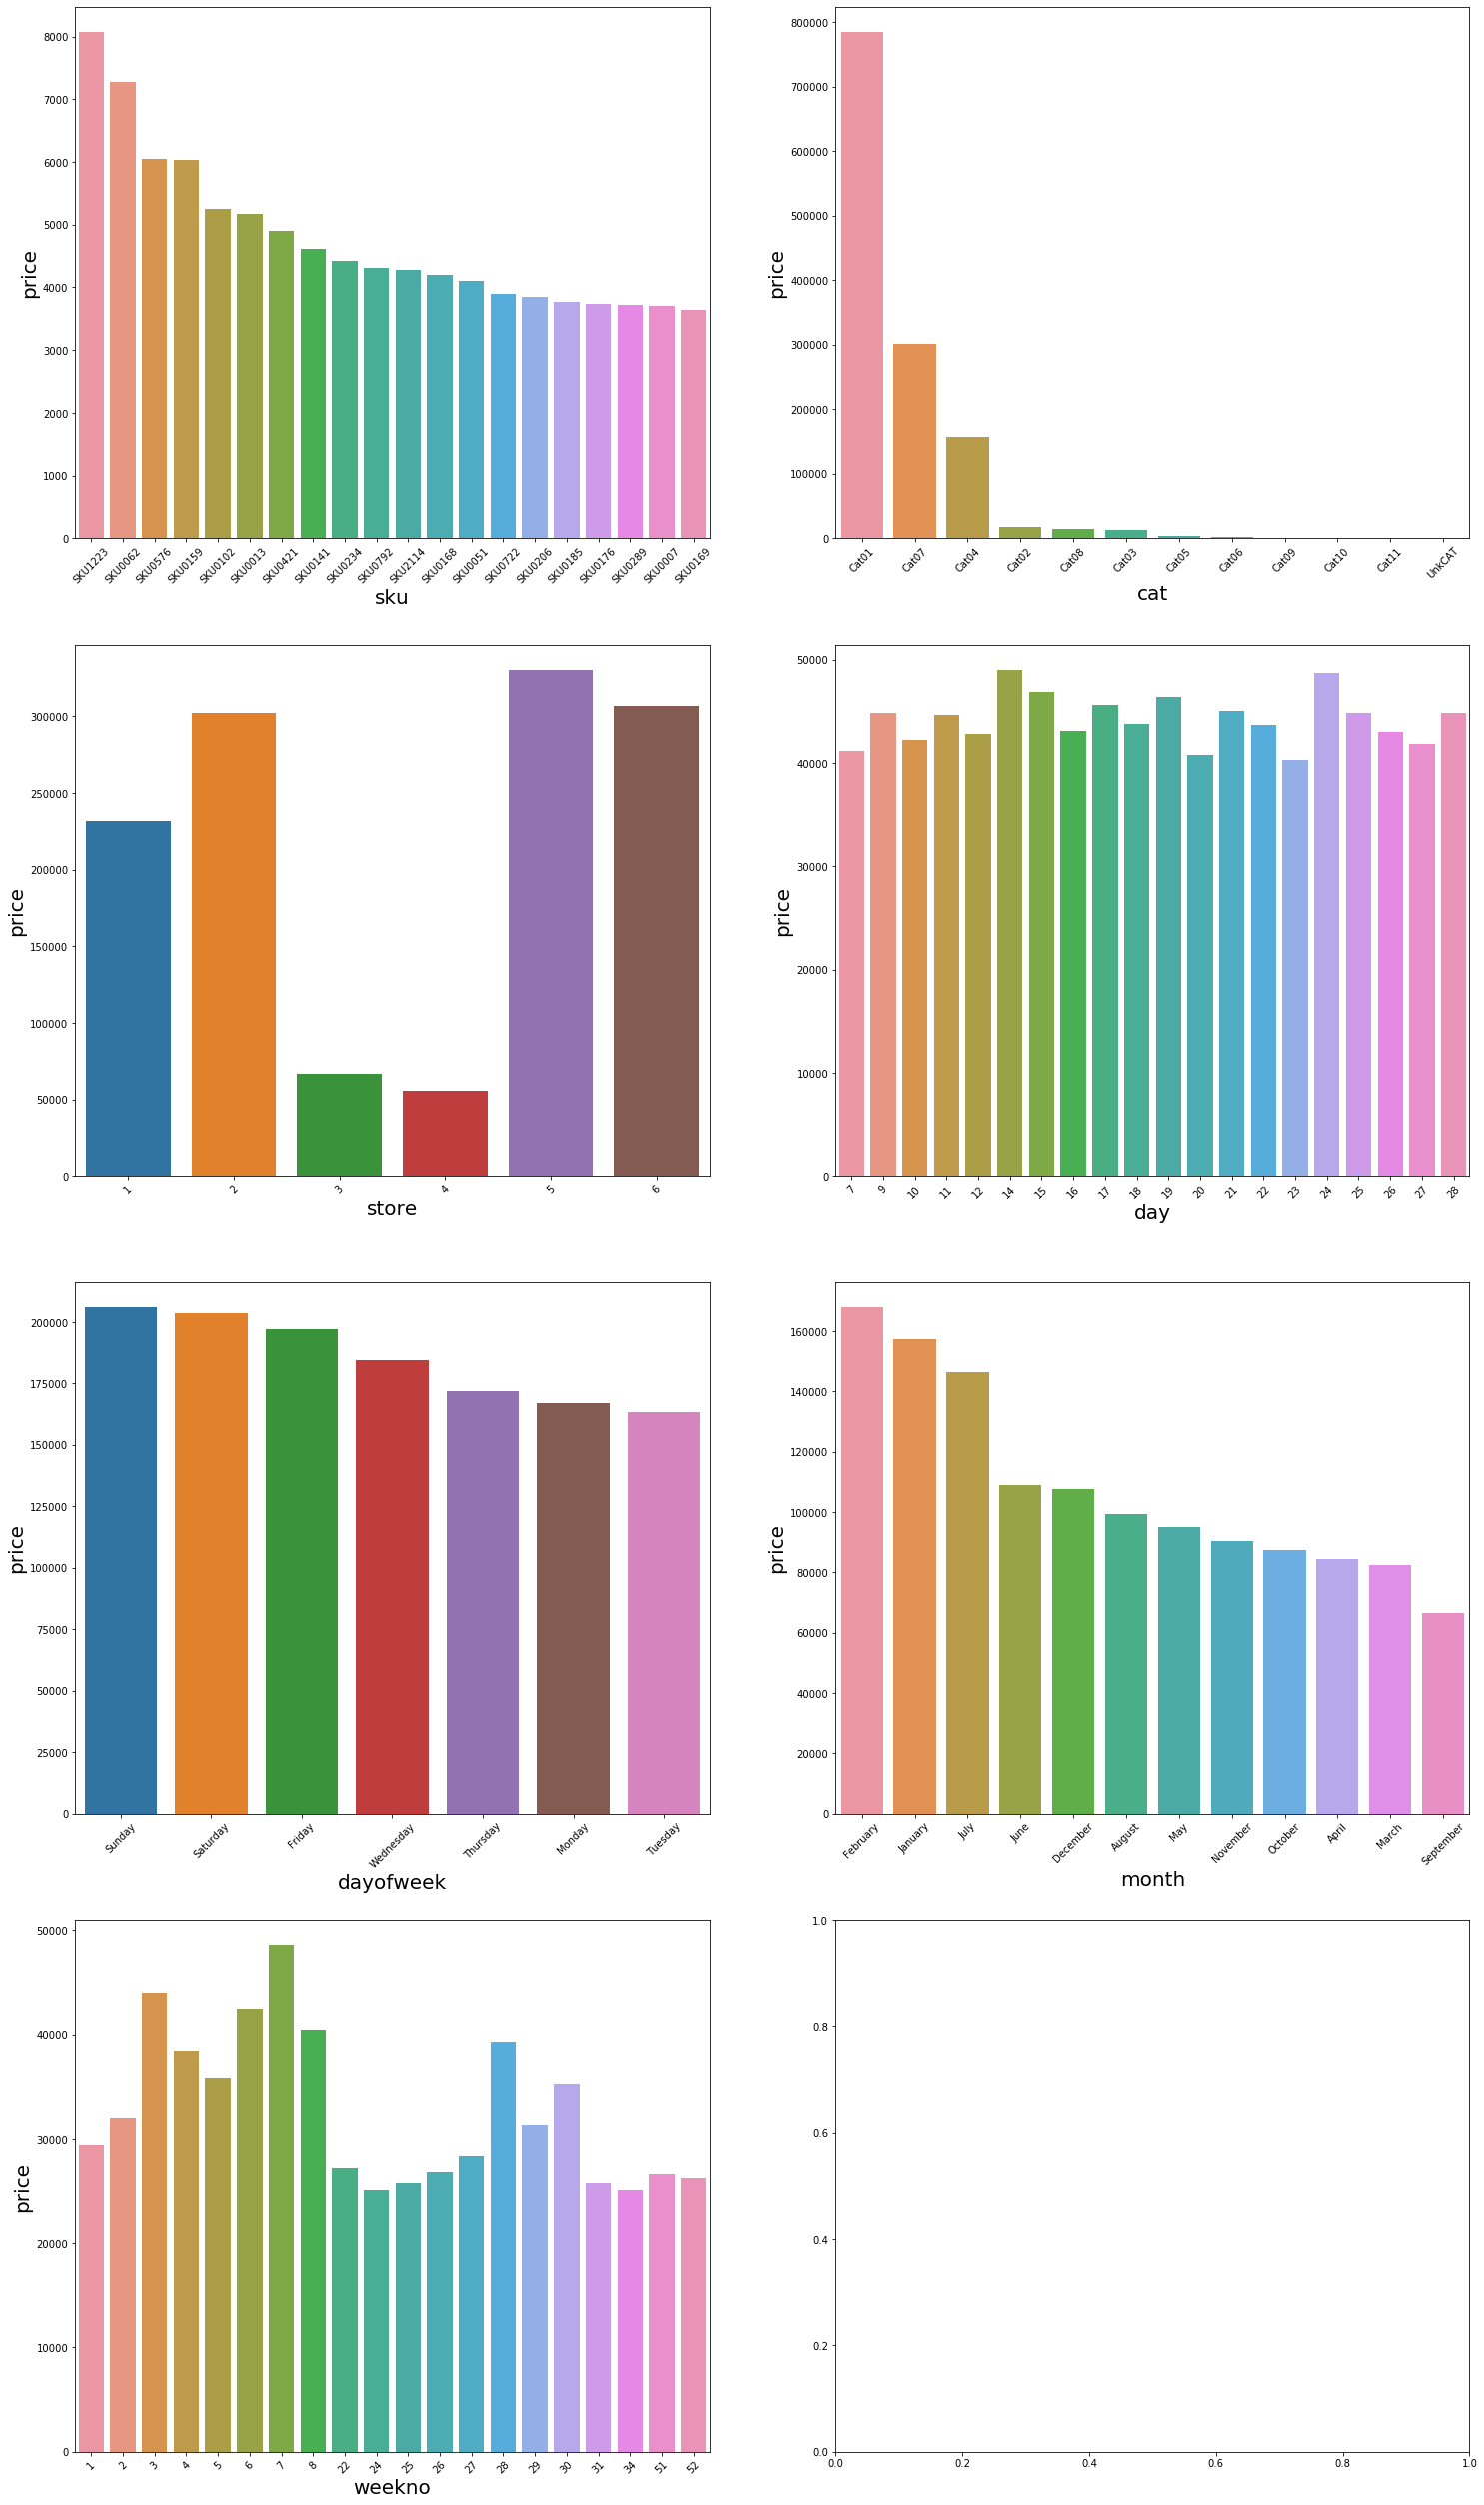

In [70]:
fig, axs = plt.subplots(4, 2, figsize = (25,45))

mean_price_per_sku, mean_price_per_sku_plot = barplot(df, 'sku', 'price', axs[0,0])

mean_price_per_cat, mean_price_per_cat_plot = barplot(df, 'cat', 'price', axs[0,1])

mean_price_per_store, mean_price_per_store_plot = barplot(df, 'store', 'price', axs[1,0])

mean_price_per_day, mean_price_per_day_plot = barplot(df, 'day', 'price', axs[1,1])

mean_price_per_dayofweek, mean_price_per_dayofweek_plot = barplot(df, 'dayofweek', 'price', axs[2,0])

mean_price_per_month, mean_price_per_month_plot = barplot(df, 'month', 'price', axs[2,1])

mean_price_per_weekno, mean_price_per_weekno_plot = barplot(df, 'weekno', 'price', axs[3,0])

In [38]:
print("Complete run")

Complete run
